# Data Cleansing: Address Cleansing

## Address Cleansing

Address cleansing, also known as address standardization or address validation, is the process of ensuring that address data is accurate, consistent, and formatted correctly. It involves correcting errors, normalizing formats, and verifying the addresses against a standardized database or reference dataset. Address cleansing is essential for maintaining data quality, improving geocoding accuracy, and ensuring successful delivery of mail or shipments.

Address cleansing can be done in following steps:

1. **Parsing**: The first step is to parse the raw address string into its individual components, such as street number, street name, street type, city, state/province, postal code, etc.

2. **Standardization**: Standardize each address component using a reference dataset or address database. This step ensures that the address follows a consistent format and is in line with postal standards.

3. **Correction**: Correct any misspelled or inaccurate address components. This may involve using a spell-checking mechanism or fuzzy matching against known address patterns.

4. **Verification**: Verify the address against a reliable address database or geocoding service to ensure that it is valid and exists in reality. This step helps identify potential issues like non-existent addresses or incorrect postal codes.

## Implementation

There are several tools and services available to help with address cleansing. Many geocoding and address verification APIs, such as Google Maps Geocoding API, Here Geocoding API, and USPS Address Validation, provide address cleansing and validation services.

We're using Python and Pandas, we can leverage external geocoding APIs or address validation libraries. For example, we chose the `geopy` library for geocoding. But we didn't choose this method at the end because we need to pay for Google APIs.

The specific steps and tools for address cleansing may vary depending on the country and region, as address formats and postal standards differ worldwide. Therefore, it's crucial to choose the appropriate tools and services based on target geography and data quality requirements.

##### Method 1: Using API to standardize the address (need to pay for the APIs)❌

In [ ]:
import pandas as pd

file = pd.read_csv('test.csv', sep=';')
file_df = pd.DataFrame(file)

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="daidabai@gmail.com")

def extract_clean_address(address):
    try:
        location = geolocator.geocode(address)
        return location.address
    except:
        return ''
file_df['clean address'] = file_df.apply(lambda x: extract_clean_address(x['building_address']) , axis =1  )
print(file_df)

##### Method 2: Using Address References to standardize and correct the address✅

In [60]:
import pandas as pd
import string
from fuzzywuzzy import process
import re

# Function to correct city name
correct_cities = ["NewSouthWales","Victoria","Queensland","NorthTeritory","Tasmania","AustralianCapitalTeritory","WesternAustralia"]  # Add all the cities you want to consider

def correct_city_name(name, correct_cities, min_score=80):
    correct_name = process.extractOne(name, correct_cities)
    if correct_name[1] >= min_score:
        return correct_name[0]
    return name

# Function to get state from postcode
def get_state(postcode):
    postcode_ranges = {
        "ACT": [(2600, 2618), (2900, 2920)],
        "NSW": [(1000, 1999), (2000, 2599), (2620, 2899), (2921, 2999)],
        "NT": [(800, 899), (900, 999)],
        "QLD": [(4000, 4999)],
        "SA": [(5000, 5799), (5800, 5999)],
        "TAS": [(7000, 7799), (7800, 7999)],
        "VIC": [(3000, 3999), (8000, 8999)],
        "WA": [(6000, 6797), (6800, 6999)]
    }
    for state, ranges in postcode_ranges.items():
        if any(start <= int(postcode) <= end for start, end in ranges):
            return state
    return "Unknown state"

# Load your excel file
df = pd.read_excel("Sample_data.xlsx")  # replace 'your_file.xlsx' with your actual file name

# Initialize empty lists to hold the postcode and state
postcodes = []
states = []
unit=[]
strt=[]
addr=[]
# For each address in the excel file
for address in df['Address']:  # replace 'Address' with your actual address column name
    # Remove punctuation and split
    #address = address.translate(str.maketrans('', '', string.punctuation))
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    address = address.translate(translator)
    
    address_parts = address.split()
    b1=address_parts.copy()
    u1=address_parts[0]
    u2=address_parts[1]
    contains_digit1= any(character.isdigit() for character in u1)
    contains_digit2= any(character.isdigit() for character in u2)
    if contains_digit1==True and contains_digit2==True:
        unit.append(u1)
        strt.append(u2)
        b1.remove(u1)
        b1.remove(u2)
    elif contains_digit1==True and contains_digit2==False:
        unit.append('')
        strt.append(u1)
        b1.remove(u1)
    else:
        unit.append('Missing Unit number')
        strt.append('Missing Street number')        
    if address_parts[-1].isdigit():
        postcode=address_parts[-1]
        flag=1
    elif address_parts[-2].isdigit():
        postcode=address_parts[-2]
        flag=1
    else:
        flag=0
        postcodes.append('Missing Postcode')
    
    if flag==1:
        state = get_state(postcode)
        if state != "Unknown state":
            postcodes.append(postcode)
            states.append(state)
            b1.remove(postcode)
        else:
            postcodes.append('Invalid Postcode')
            states.append('Invalid Postcode')

    if flag==0:
        d=b1[-1]
        if d in ("ACT","NSW","VIC","NT","TAS","WA","QLD"):
            states.append(d)
            b1.remove(d)
        else:
            s4=''.join(b1)
            d=correct_city_name(s4,correct_cities)
            if d==s4:
                states.append('Missing value for state')
            else:
                matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', d)
                s6=' '.join(matches)
                if s6=="New South Wales":
                    states.append("NSW")
                 
                elif s6=="Queensland":
                  states.append("QLD")
               
                elif s6=="Victoria":
                    states.append("VIC")
                
                elif s6=="Australian Capital Teritory":
                    states.append("ACT")
                 
                elif s6=="North Teritory":
                    states.append("NT")
                  
                elif s6=="Tasmania":
                    states.append("TAS")
              
                elif s6=="Western Australia":
                    states.append("WT")
                   
    t5=b1[0] + '  '+ b1[1] + ' & ' +b1[2]
    print(t5)
    addr.append(t5)
    
df['Unit Number']=unit
df['Street Number']=strt
df['Street and Suburb Name']=addr
df['States']=states
df['Postcode'] = postcodes

# Save the updated dataframe back to the Excel file
df.to_excel("Sample_data.xlsx", index=False)


Jms  Plce & Sydney
Peers  St & Mlb
Elizabeth  St & Hbart
Chrls  St & Pth
Grnwich  Rd & Adld
Pclfc  Hwy & Dwn
Clarence  St & Sydney
Kng  St & Melbourne
Flndrs  Ln & Melbourne
Lttle  Bourke & St
Mrrywell  St & Pth
St  Georges & Trce
Adlde  St & Brisbane
Crrck  Hill & Rd
Hgh  St & Toowoomba
Rndwck  Rd & Sydney
Grnville  Rd & Parramatta
Cllins  St & Melbourne
Qeen  St & Brisbane
Frnklin  St & Adld
Frry  Rd & Wst
Ann  St & Brsbne
Edward  St & Brisbane
George  St & Prrmatta
Crwn  St & Wllongong
Mttn  Bay & Rd
Clarendn  St & Sth
Wlliam  St & Perth
Brrack  St & Sydney
Mntague  St & Sth
St  Klda & Rd
Qeen  St & Melbourne
Sprng  St & Melbourne
Bnd  St & Sydney
Wlliam  St & Melbourne
Kng  St & Pth
St  George’s & Tce
Mrrison  St & Hbart
Sth  Tce & Adld
Smmers  St & Pth
Wlliam  St & Brsbane
St  Klda & Rd
Blmore  St & Sydney
Qeen  St & Melbourne
Sprng  St & Sydney
Gerge  St & Prrmatta
Pclfc  Hwy & Newcstle
Wlliam  St & Adld
Sth  Tce & Adld
Grgory  Tce & Brisbane
Collins  Street & MELBOURNE


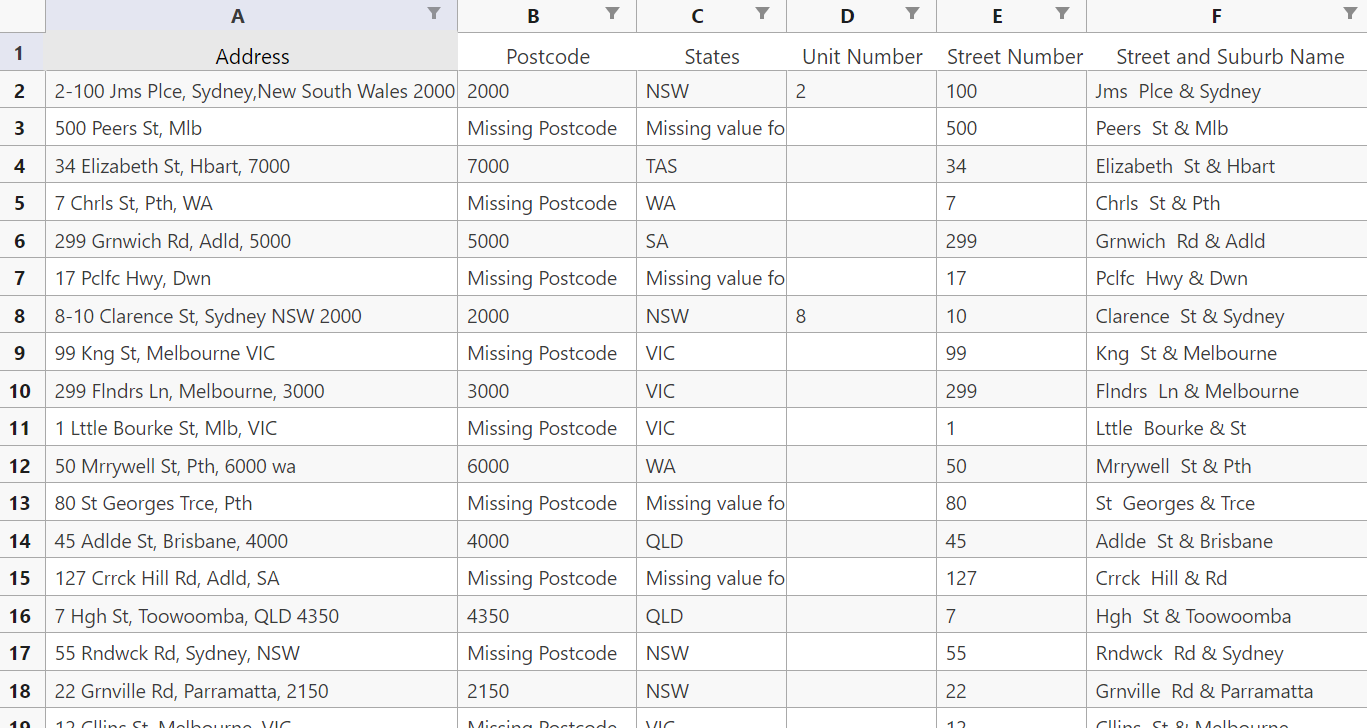

### In the Future: Verification

This can be verified with Google Map APIs or Addressr(https://github.com/mountain-pass/addressr) in the future work. (we'll explore this in the next days)

This python tool can be integrated with SSIS (SQL Server Integration Services) to facilitate the execution of a data pipeline that performs data cleansing tasks for our database.

## Conclusion

In conclusion
1. Parsing: 
We've parsing unit number, street number, street name/street type, city/suburb, state, postal code and parse the original data to individual components.

2. Standardization and Correction: 
After exploring various options for address validation, we decided not to go with the paid Google APIs due to cost considerations. The free APIs proved to be insufficient in terms of performance and accuracy. 
Consequently, we chose to develop our own custom framework for address cleansing. This approach allowed us to tailor the solution to our specific requirements, ensuring better control over the data and potential long-term cost savings. 

3. Validation:
We would work on this part in the future. There is one free tool "Addressr" we could explore more to see if it would meet our requirement. 

Address cleansing is a critical aspect of our operations, and our decision to create a dedicated framework demonstrates our commitment to finding the most suitable and effective solution for our organization's needs.